# Задачи регрессии SI

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,  FunctionTransformer
from sklearn.pipeline import Pipeline

from catboost import  Pool
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
# Прочитаем обработанный датасет
df = pd.read_csv('./data_him.csv')

In [3]:
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,Polar_Groups_Count,Lipophilic_Groups_Count,PLB,HBond_Capacity,HBond_Donor_Acceptor_Ratio,Saturation_Index,Hydrophobic_VSA,BCUT_Electronic,Size_Flexibility,LogD
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,3,0.0,2,0.0,1.000000,173.744106,38.545778,26.92564,7.1212
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,3,0.0,4,1.0,1.000000,175.053185,39.145933,34.98156,6.1556
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,3,0.0,0,0.0,1.000000,201.576358,40.922447,40.21272,7.1292
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,4,0.0,2,0.0,1.000000,180.164927,38.542997,31.89432,7.5113
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0.0,2,0.0,0.666667,201.049968,38.597756,18.66852,9.1148


In [4]:
df.shape

(970, 213)

In [5]:
cat_features = ['NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 
                'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
                'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
                'RingCount', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_N', 'fr_Ar_OH',
                'fr_C_O', 'fr_C_O_noCOO', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 
                'fr_Ndealkylation2', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline',
                'fr_aryl_methyl', 'fr_benzene', 'fr_bicyclic', 'fr_epoxide', 'fr_ester', 
                'fr_ether', 'fr_furan', 'fr_halogen', 'fr_hdrzone', 'fr_ketone', 'fr_ketone_Topliss',
                'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_oxime', 'fr_para_hydroxylation', 
                'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_piperdine', 'fr_piperzine', 'fr_quatN', 
                'fr_sulfide']
numeric_features = [ 'MaxAbsEStateIndex', 'MaxEStateIndex', 
                    'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 
                    'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
                    'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 
                    'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
                    'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 
                    'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ',
                    'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
                    'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 
                    'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10',
                    'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 
                    'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 
                    'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4',
                    'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',
                    'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 
                    'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10',
                    'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
                    'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState10',
                    'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6',
                    'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount',
                    'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 
                    'NumRotatableBonds', 'MolLogP', 'MolMR', 'fr_NH0', 'fr_unbrch_alkane']
bool_features = ['fr_Al_COO', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_COO', 'fr_COO2', 'fr_C_S', 'fr_HOCCN', 
                 'fr_Nhpyrrole', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azo', 
                 'fr_guanido', 'fr_hdrzine', 'fr_imidazole', 'fr_imide', 'fr_nitrile', 'fr_nitro',
                 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_oxazole', 'fr_priamide', 
                 'fr_pyridine', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
                 'fr_thiazole', 'fr_thiophene', 'fr_urea']

In [6]:
# Резделение выборки
y = np.log1p(df['SI'])
X = df.drop(['IC50, mM','CC50, mM', 'SI', 'Unnamed: 0'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.15, random_state=62025)

In [7]:
X_train.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'Polar_Groups_Count', 'Lipophilic_Groups_Count', 'PLB',
       'HBond_Capacity', 'HBond_Donor_Acceptor_Ratio', 'Saturation_Index',
       'Hydrophobic_VSA', 'BCUT_Electronic', 'Size_Flexibility', 'LogD'],
      dtype='object', length=209)

In [8]:
# Создаем копии данных для обработки
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Преобразование типов данных
X_train_processed[cat_features] = X_train_processed[cat_features].astype('category')
X_test_processed[cat_features] = X_test_processed[cat_features].astype('category')

# Исправление: Преобразование bool в int (0/1) ДО масштабирования
X_train_processed[bool_features] = X_train_processed[bool_features].astype(int)
X_test_processed[bool_features] = X_test_processed[bool_features].astype(int)

# Масштабирование только числовых признаков
scaler = StandardScaler()
X_train_processed[numeric_features] = scaler.fit_transform(X_train_processed[numeric_features])
X_test_processed[numeric_features] = scaler.transform(X_test_processed[numeric_features])


In [9]:
# Создание модели
model = CatBoostRegressor(
    cat_features=cat_features,
    #task_type="GPU", 
    #devices='0-3',
    loss_function='RMSE',
    verbose=50
    
)

In [10]:
# Создание модели
# Сетка параметров для поиска
param_grid = {
    'iterations': [100, 150, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05, 0.5],
    'l2_leaf_reg': [1, 3, 5]
}


In [11]:
# Пользовательская метрика RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

In [ ]:
# Обучение модели
grid_search.fit(X_train_processed, y_train)


In [15]:
# Лучшая модель
best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучшая RMSE (кросс-валидация):", grid_search.best_score_)

# Предсказание на тестовом наборе
y_pred = best_model.predict(X_test_processed)
test_rmse = rmse(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nТестовая RMSE:", test_rmse)
print("Тестовый R2:", test_r2)

# Сравнение с baseline
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = rmse(y_test, baseline_pred)
print("\nBaseline RMSE (предсказание средним):", baseline_rmse)
print("Улучшение над baseline:", round((1 - test_rmse/baseline_rmse)*100, 1), "%")


Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Лучшая RMSE (кросс-валидация): 0.2586267062928417

Тестовая RMSE: 0.9848699894918986
Тестовый R2: 0.3754899051780337

Baseline RMSE (предсказание средним): 1.261103284258884
Улучшение над baseline: 21.9 %


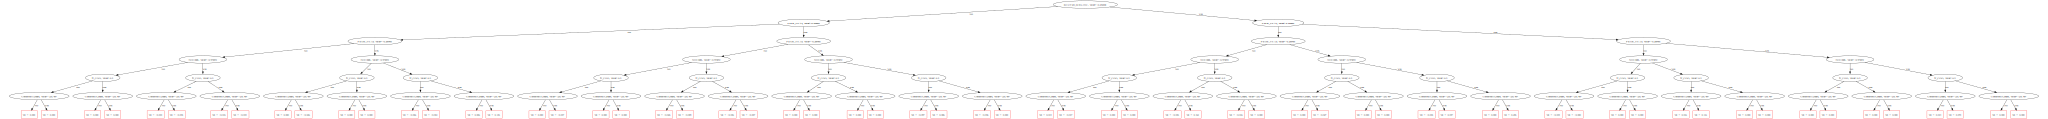

In [16]:
pool = Pool(X_train_processed, y_train, cat_features=cat_features, feature_names=list(X_train_processed.columns))

best_model.plot_tree(
    tree_idx=0,
    pool=pool
)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
# Подготовка данных
features = cat_features + numeric_features + bool_features
y = np.log1p(df['SI'])
X = df[features]

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=62025
)

# Обработка для нейросети

# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop'
)

# Применяем преобразования
X_train_pt = preprocessor.fit_transform(X_train)
X_test_pt = preprocessor.transform(X_test)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_pt.astype(np.float32), device=device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), device=device)
X_test_tensor = torch.tensor(X_test_pt.astype(np.float32), device=device)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), device=device)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем размерность входа
input_dim = X_train_pt.shape[1]

# Сама структура сети
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.75),

            # nn.Linear(2048, 1024),
            # nn.ReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Dropout(0.8),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Инициализация модели
model_pt = RegressionNN(input_dim).to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.01)

# Планировщик скорости обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.9, patience=5, verbose=True
)

# ОБУЧЕНИЕ МОДЕЛИ

num_epochs = 100
best_loss = float('inf')
patience = 15
patience_counter = 0

# Цикл обучения
for epoch in range(num_epochs):
    # Режим обучения
    model_pt.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model_pt(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Средняя потеря за эпоху
    train_loss /= len(train_loader.dataset)
    
    # Режим оценки
    model_pt.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_pt(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    scheduler.step(val_loss)
    
    # Вывод статистики
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
    # Ранняя остановка
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        # Сохранение лучшей модели
        torch.save(model_pt.state_dict(), 'best_model_pt.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Ранняя остановка на эпохе {epoch+1}')
            break


Используемое устройство: cuda
Epoch [1/100] | Train Loss: 5.738122 | Val Loss: 2.768614


D:\jupiter\conda_inst\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [2/100] | Train Loss: 4.581709 | Val Loss: 2.661161
Epoch [3/100] | Train Loss: 3.682224 | Val Loss: 2.686462
Epoch [4/100] | Train Loss: 2.616948 | Val Loss: 1.484157
Epoch [5/100] | Train Loss: 2.079562 | Val Loss: 1.325956
Epoch [6/100] | Train Loss: 1.928030 | Val Loss: 1.320299
Epoch [7/100] | Train Loss: 1.831140 | Val Loss: 1.267076
Epoch [8/100] | Train Loss: 1.596900 | Val Loss: 1.218583
Epoch [9/100] | Train Loss: 1.700950 | Val Loss: 1.052891
Epoch [10/100] | Train Loss: 1.590376 | Val Loss: 1.047514
Epoch [11/100] | Train Loss: 1.599459 | Val Loss: 1.148352
Epoch [12/100] | Train Loss: 1.545337 | Val Loss: 1.125608
Epoch [13/100] | Train Loss: 1.485042 | Val Loss: 1.046120
Epoch [14/100] | Train Loss: 1.522791 | Val Loss: 1.050145
Epoch [15/100] | Train Loss: 1.542455 | Val Loss: 1.115529
Epoch [16/100] | Train Loss: 1.436083 | Val Loss: 1.088069
Epoch [17/100] | Train Loss: 1.363350 | Val Loss: 1.055742
Epoch [18/100] | Train Loss: 1.405156 | Val Loss: 1.129408
Epoch

In [57]:
# ОЦЕНКА МОДЕЛИ

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Предсказание на тестовом наборе
all_preds = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model_pt(inputs)
        all_preds.append(outputs.cpu().numpy())

y_pred_pt = np.concatenate(all_preds).flatten()

# Расчет метрик
test_rmse_pt = rmse(y_test, y_pred_pt)
test_r2_pt = r2_score(y_test, y_pred_pt)

print("\n[PyTorch] Тестовая RMSE:", test_rmse_pt)
print("[PyTorch] Тестовый R2:", test_r2_pt)


[PyTorch] Тестовая RMSE: 0.98504447412039
[PyTorch] Тестовый R2: 0.3752686027408386


# Вывод:
Что касается данной задачи регрессии, то можно отметить регрессионные модели лучше предсказывают искомый показатель, в данном случае SI - индекс силективности.
Что касается выбора лучшей модели, CAT BOOST и нейронная сеть показали одинаковый результат. 
Но выбор отдаю, той модели которую можно проанализировать - CAT BOOST. 